# Introduction to the nrt Ecosystem

This notebook introduces the `nrt` ecosystem, a collection of Python tools designed for near-real-time monitoring and analysis of forest disturbances. The ecosystem consists of several packages, including:

- `nrt`: The core package implementing various disturbance monitoring algorithms in an efficient and standardized way
- `nrt-data`: Facilitates access to demonstration datasets that are pre-processed and ready for analysis.
- `nrt-validate`: Provides functionalities for algorithm selection, parameter tuning, monitoring performance validation and reference data creation.

The notebook is organized into three main sections:

- **Data download and preparation:** Using `nrt-data` to access and prepare relevant datasets for analysis.
- **Optimal parameter search:** Leveraging functionalities of `nrt-validate` to perform algorithm selection and parameter optimization.
- **Production of disturbance maps and visualization:** Generating and visualizing forest disturbance maps based on selected algorithms and optimal parameters.


In [69]:
import datetime, os
from pprint import pprint
import io, base64

import pandas as pd
import numpy as np
import xarray as xr
import rioxarray
import rasterio
from rasterio import features
from rasterio import warp
from rasterio.crs import CRS
import fiona
import gdown

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
from ipyleaflet import Map, basemaps, ImageOverlay, LayersControl
from ipywidgets import Layout
from sidecar import Sidecar

from nrt.monitor.iqr import IQR
from nrt.monitor.ewma import EWMA
from nrt.monitor.cusum import CuSum
from nrt.monitor.mosum import MoSum

from nrt import data

from nrt.validate.indices import CR_SWIR
from nrt.validate.xr_transforms import S2CloudMasking
from nrt.validate.utils import combine_transforms
from nrt.validate.algorithm_selection import GridSearch
from nrt.validate.metrics import f1_score_at_lag

## Data Download and Preparation

The `nrt-data` package (imported as `from nrt import data`) provides access to multiple test and demonstration datasets. In this notebook, we focus on an area covering 400 km² located east of Cologne, in the North Rhine-Westphalia state of Germany. This region has been heavily affected by bark beetle epidemics.

As the goal is to identify optimal parameters and monitoring algorithms for efficient early detection of canopy dieback and clearcuts, we require the following:

- **Optical data stack**: We use a dense time series of Sentinel-2 surface reflectance data at 10m resolution, accessible via streaming through `nrt.data.germany_zarr()`. This is a good example of streaming access to cloud-optimized geospatial formats. For the purposes of this tutorial, a subset of the dataset has been prepared in netCDF format though, as remote access of full Zarr archive can be slow for large datasets.
  
- **Reference data**: We need reference points that include both positive (with precise timing of dieback or clearcut events) and negative (stable forest) examples. This reference data was generated through visual interpretation of spectral trajectories at sample locations using the `nrt.validate.interface.SegmentsLabellingInterface`. The raw data is available via `nrt.data.germany_temporal_segments()`. A reshaped and filtered version is provided in the `data` directory for this tutorial. 

For those interested in more detailed data preparation processes, the scripts used to prepare this data are available in the `scripts/` directory.

More details on these datasets, such as sampling design, limitations, or value encoding, can be found in the respective help pages (e.g., `help(data.germany_sample_points)` for sampling design information).


In [12]:
# Details on raw reference data
help(data.germany_temporal_segments)

Help on function germany_temporal_segments in module nrt.data:

germany_temporal_segments()
    Visually interpreted temporal segments for 300 sample locations in Germany.
    
    This function loads temporal segmentation data, which has been visually
    interpreted using the ``SegmentLabellingInterface`` of the ``nrt-data`` package.
    The data corresponds to the sample locations from ``nrt.data.germany_sample_points()``
    and can be joined with it using the ``fid`` or ``feature_id`` keys.
    
    Each segment is labeled with one of three possible categories:
    
        - Non-treed
        - Stable tree cover
        - Dieback
    
    A common disturbance trajectory in this region, which has been heavily
    affected by bark beetle activity, follows the pattern "Stable tree cover",
    "Dieback", and then "Non-treed." For some sample locations, no label could be
    confidently assigned, and these are represented with a single segment labeled `None`.
    
    Additional infor

### Cube and reference data loading

In [73]:
cube_path = '../data/germany.nc'

# Check if file exists, if not, download it
if not os.path.exists(cube_path):
    url = 'https://drive.google.com/uc?export=download&id=1Us9kRu1czEfkTw_jqlKZcCLHtPrrFGG-'
    gdown.download(url, cube_path, quiet=False)
cube = xr.open_dataset(cube_path, decode_cf=True).chunk(chunks={'time': 10, 'y': 400, 'x': 400})

# Load feature collection (should already be present in repository)
with fiona.open('../data/fc.fgb') as con:
    fc = list(con)

# Display the dataset
cube

<xarray.Dataset> Size: 13GB
Dimensions:      (time: 134, y: 2000, x: 2000)
Coordinates:
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 1kB 2018-02-14T10:31:31.026000 ... 202...
  * x            (x) float64 16kB 4.133e+06 4.133e+06 ... 4.153e+06 4.153e+06
  * y            (y) float64 16kB 3.113e+06 3.113e+06 ... 3.093e+06 3.093e+06
Data variables:
    B08          (time, y, x) float64 4GB dask.array<chunksize=(10, 400, 400), meta=np.ndarray>
    B11          (time, y, x) float64 4GB dask.array<chunksize=(10, 400, 400), meta=np.ndarray>
    B12          (time, y, x) float64 4GB dask.array<chunksize=(10, 400, 400), meta=np.ndarray>
    SCL          (time, y, x) uint8 536MB dask.array<chunksize=(10, 400, 400), meta=np.ndarray>

In [3]:
# Display one feature (since fiona 2.0, features are no longer simple dictionaries, but they still inherit all dictionary methods)
# Disturbance data in days since epoch (1970-1-1)
fc[14]['properties']

fiona.Properties(stratum=3, fid=101, forest=True, disturbance_date=18571)

### Cloud masking and CR-SWIR calculation

The monitoring methods implemented in `nrt` operate on univariate time-series, requiring the computation of a spectral indices that are both sensitive and specific to the process being monitored. **CR-SWIR** (Continuum Removal SWIR) has proven effective at detecting early signs of evergreen canopy dieback (e.g., loss of water content). By construction, CR-SWIR is relatively insensitive to noise, such as variations in atmospheric correction, making it a robust choice for this task.

CR-SWIR takes advantage of the water absorption feature in the SWIR1 region of the electromagnetic spectrum. The nrt-validate package provides utilities to easily mask clouds in Sentinel-2 datasets, compute CR-SWIR, and generate other indices.

In [74]:
# COmpute CR-SWIR and split between history and monitor dataArrays (da)
pp = combine_transforms(S2CloudMasking(), CR_SWIR(nir='B08')) # pp stands for pre-processor
crswir_da = pp(cube)
crswir_da_history = crswir_da.sel(time=slice(None, datetime.datetime(2019,12,31))).compute()
crswir_da_monitor = crswir_da.sel(time=slice(datetime.datetime(2020,1,1), None)).compute()


## Optimal Parameter Search

This section of the notebook focuses on parameter optimization to identify the most suitable algorithm and its parameters for efficient forest disturbance monitoring in a specific context. Given the various tuning possibilities across the different `nrt` monitoring algorithms, gaining an intuition for the best settings can be challenging. To assist with this, we have developed a grid search functionality, inspired by scikit-learn's `GridSearchCV`, that enables quick testing of multiple parameter combinations.

The following components are key for this process:

- A **scoring function**: We use `nrt.validate.metrics.f1_score_at_lag()`, which computes the F1 score for a user-defined lag.
- The **`GridSearch` class** from `nrt.validate.algorithm_selection`.
- The **reference data** previously loaded.
- The **result generation data**, specifically `crswir_da_history` and `crswir_da_monitor`.

### Scoring Function Details
In this example, we use a lag of 90 days, which serves as a temporal threshold for evaluating monitoring performance. This lag reflects a reasonable timeframe to expect accurate detection of forest disturbances. Specifically, if a disturbance is detected within 60 days of the actual event, it is considered a True Positive; otherwise, it is treated as a False Negative.

<div class="alert alert-block alert-info">
<b>Note:</b> The `nrt-validate` package is currently in an alpha stage, and some features are still under development. For example, functions in the metrics submodule do not yet account for sample weights (which are typically derived from inclusion probabilities). Additionally, these functionalities are subject to change.
</div>



In [75]:
# Reference data have to be provided as an iterable of (geometry, value) pairs
shapes_true = [(feat['geometry'], feat['properties']['disturbance_date'])
               for feat in fc]

# Define parameter grid for EWMA
param_grid_ewma = {
    'trend': [False],
    'harmonic_order': [0, 1, 2],
    'sensitivity': [1, 2, 3],
    'lambda_': [0.1, 0.3, 0.5],
    'threshold_outlier': [5, 10, 15]
}

# Instantiate GridSearch
gs_ewma = GridSearch(algorithm=EWMA, param_grid=param_grid_ewma, scoring=f1_score_at_lag)
# Fit the model and search for the best parameters
gs_ewma.fit(history_da=crswir_da_history, monitor_da=crswir_da_monitor, shapes_true=shapes_true,
            reduce_shape=True, lag=90, begin=datetime.datetime(2020,1,1), negative_tolerance=20)

# Get the best parameters and score
best_params = gs_ewma.best_params()
best_score = gs_ewma.best_score()

print(f"Best Parameters: {best_params}") # {'trend': False, 'harmonic_order': 2, 'sensitivity': 1, 'lambda_': 0.5, 'threshold_outlier': 10}
print(f"Best Score: {best_score}") # 0.79012


Best Parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 1, 'lambda_': 0.5, 'threshold_outlier': 10}
Best Score: 0.7901234567901234


In [61]:
# Define parameter grid for mosum (bfastmonitor)
param_grid_mosum = {
    'trend': [False],
    'harmonic_order': [0, 1, 2],
    'sensitivity': [0.01, 0.05],
    'h': [0.25, 0.5, 1]
}

# Instantiate GridSearch
gs_mosum = GridSearch(algorithm=MoSum, param_grid=param_grid_mosum, scoring=f1_score_at_lag)
# Fit the model and search for the best parameters
gs_mosum.fit(history_da=crswir_da_history, monitor_da=crswir_da_monitor, shapes_true=shapes_true,
            reduce_shape=True, lag=90, begin=datetime.datetime(2020,1,1), negative_tolerance=20)

# Get the best parameters and score
best_params = gs_mosum.best_params()
best_score = gs_mosum.best_score()

print(f"Best Parameters: {best_params}") # {'trend': False, 'harmonic_order': 0, 'sensitivity': 0.01, 'h': 1}
print(f"Best Score: {best_score}") # 0.63013

/home/loic/.virtualenvs/nrt-workshop/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/loic/.virtualenvs/nrt-workshop/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/loic/.virtualenvs/nrt-workshop/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/loic/.virtualenvs/nrt-workshop/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/loic/.virtualenvs/nrt-workshop/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of f

Best Parameters: {'trend': False, 'harmonic_order': 0, 'sensitivity': 0.01, 'h': 1}
Best Score: 0.6388888888888888


In [62]:
# Define parameter grid for IQR
param_grid_iqr = {
    'trend': [False],
    'harmonic_order': [0, 1, 2],
    'sensitivity': [0.5, 1, 1.5, 2],
    'boundary': [2,3,4,5]
}

# Instantiate GridSearch
gs_iqr = GridSearch(algorithm=IQR, param_grid=param_grid_iqr, scoring=f1_score_at_lag)
# Fit the model and search for the best parameters
gs_iqr.fit(history_da=crswir_da_history, monitor_da=crswir_da_monitor, shapes_true=shapes_true,
            reduce_shape=True, lag=90, begin=datetime.datetime(2020,1,1), negative_tolerance=20)

# Get the best parameters and score
best_params = gs_iqr.best_params()
best_score = gs_iqr.best_score()

print(f"Best Parameters: {best_params}") # {'trend': False, 'harmonic_order': 0, 'sensitivity': 0.5, 'boundary': 2}
print(f"Best Score: {best_score}") # 0.744186

Best Parameters: {'trend': False, 'harmonic_order': 0, 'sensitivity': 0.5, 'boundary': 2}
Best Score: 0.7191011235955056


## Map production and visualization

Now that we have discovered an optimal set of parameters, we can use it to run a monitoring simulation for the entire study area, and visualize the results.

In [76]:
# Use reclassified stratification as mask
mask = data.germany_stratification()
mask[mask == 1] = 0
mask[np.isin(mask, [2, 3, 4, 5])] = 1

# Instantiate EWMA with GridSearch parameters results
nrt_monitor = EWMA(mask=mask, **gs_ewma.best_params())

# Fit
nrt_monitor.fit(crswir_da_history)

# Run monitor for each observations of year 2020
monitor_da = crswir_da_monitor.sel(time=slice(None, '2020-12-31'))
for array, date in zip(monitor_da.values, monitor_da.time.values.astype('datetime64[s]').tolist()):
    nrt_monitor.monitor(array=array, date=date)

Simple visualization with matplotlib.

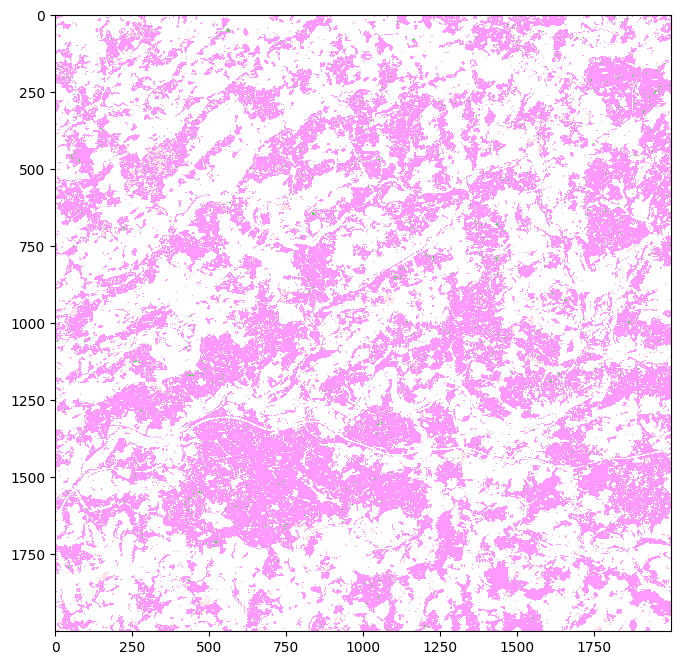

In [77]:
# Visualize
mask_cmap = ListedColormap([(0, 0, 0, 0), # Zero, not monitored
                            (0, 1, 0, 0.9), # 1: monitored, undisturbed. Green
                            (1, 0, 0, 0.1), # UNstable history or not enough data
                            (1, 0, 1, 0.4)]) # Break detected
plt.figure(figsize=(8, 8))
plt.imshow(nrt_monitor.mask, cmap=mask_cmap, interpolation='none')

While the `GridSearch` provided a set of EWMA parameters with a promising accuracy metric, applying this combination to the entire study area produced unexpected results. Nearly the entire forested area was flagged within a year, suggesting either an overly sensitive model or systematic outliers in the monitoring data. Understanding the reasons for this outcome, and the discrepancy between the  GridSearch  results and the actual test, will require further investigation. Interactive tools for visually inspecting the monitoring process would be helpful in diagnosing the source of these commission errors. Stay tuned!!

In the meantime, we were able to produce visually coherent results using IQR with a manually tuned set of parameters. Let's produce it and visualize it in an interactive web map.

In [78]:
mask = data.germany_stratification()
mask[mask == 1] = 0
mask[np.isin(mask, [2, 3, 4, 5])] = 1

nrt_monitor = IQR(mask=mask, boundary=5, sensitivity=3)

nrt_monitor.fit(crswir_da_history)

monitor_da = crswir_da_monitor.sel(time=slice(None, '2020-12-31'))
for array, date in zip(monitor_da.values, monitor_da.time.values.astype('datetime64[s]').tolist()):
    nrt_monitor.monitor(array=array, date=date)

Helper function to overlay a numpy array on a leaflet map

In [91]:
def png_url_from_array(arr, src_crs, src_transform):
    """Generate a byte image url to be added to leaflet

    Takes care of warping to pseudo mercator
    Only work for single band array, zero is set to transparent in png settings
    """
    arr_3857, dst_transform  = warp.reproject(source=arr, src_transform=src_transform,
                                              src_crs=src_crs, dst_crs=CRS.from_epsg(3857))
    arr_3857 = np.squeeze(arr_3857)
    left, bottom, right, top = rasterio.transform.array_bounds(height=arr_3857.shape[0],
                                             width=arr_3857.shape[1],
                                             transform=dst_transform)
    # Get image bounds in leaflet format
    [left,right], [bottom,top] = warp.transform(src_crs=CRS.from_epsg(3857),
                                                dst_crs=CRS.from_epsg(4326),
                                                xs=[left, right], ys=[bottom, top])
    leaflet_bounds = ((bottom,left), (top,right))
    # Build png image and url
    img = Image.fromarray(arr_3857, mode='P')
    palette = [0, 0, 0, 0, # Zero, not monitored
                0, 255, 0, 200, # 1: monitored, undisturbed. Green
                200, 0, 0, 100, # UNstable history or not enough data
                255, 0, 255, 150]
    img.putpalette(palette, rawmode='RGBA')
    with io.BytesIO() as fileobj:
        img.save(fileobj, 'PNG')
        img_bytes = fileobj.getvalue()
        img_url = 'data:image/png;base64,' + base64.b64encode(img_bytes).decode('ascii')
    return img_url, leaflet_bounds

In [103]:
img_url, bounds = png_url_from_array(nrt_monitor.mask, src_crs=cube.rio.crs, src_transform=cube.rio.transform())
m = Map(center=(51.00, 7.47),
        zoom=12,
        basemap=basemaps.Esri.WorldImagery,
        layout=Layout(height='700px'),
        scroll_wheel_zoom=True)
overlay = ImageOverlay(url=img_url,
                       bounds=bounds,
                       name='nrt mask')
control = LayersControl(position='topright')
m.add_layer(overlay)
m.add_control(control)
sc = Sidecar(title='NRT results')
with sc:
    display(m)

Map(center=[51.0, 7.47], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…